# The Hubble Constant and the Age of the Universe

#### R. K Daniels

The aim of this notebook is to estimate the age of the universe. The intrinsic brightness of a star can be found if the distance to the star is known and the apparent brightness as it appears to us is measured. In order to judge the distance to a star in a nearby galaxy, both the apparent and absolute brightness of the star must be known. Since the apparent magnitude is measured, all that remains is to find a way to determine the absolute brightness of a star, and the distance to that star can be determined. Cepheid stars are pulsating stars whose period is related to their intrinsic brightness. If we can find this *Period-luminosity* relationship, then the intrinsic brightness of any Cepheid star can be found, and hence the distance of that star from Earth can be determined.

The first datasets contain information for us to determine the PL relation. Parallax can be used to determine the distance to stars in our own galaxy (parallax is not measurable for stars in distance galaxies), and this can be used to find the absolute magnitude of a star if its distance is known. We will use Cepheid stars whose distances from Earth are known in order to find their absolute magnitudes, and using the period of pulsation, find the PL relations for two bands of light: visual and infrared. These PL relations can then be used to find the absolute magnitudes of Cepheid stars in distance galaxies. Using Hubble's Law, which is a linear relationship between the distance to a galaxy and its recession velocity, we can then determine the Hubble Constant, and from this, the age of the Universe.

## Import statements

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.stats import norm
import pylab
from IPython.display import display, Math
pylab.rcParams['figure.figsize'] = (16.0, 14.0)

## An initial look at the data

In [2]:
filename = 'MW_Cepheids.dat'
# Import the data and clean up the rows and column names
MW_Cepheids = pd.read_csv(filename, skiprows=[1,2], sep='\s+')
MW_Cepheids = MW_Cepheids.rename(columns={'#Object':'Object'})

In [3]:
MW_Cepheids

,Object,parallax,err(par),Period,m_V,m_I,A_V,err(A_V)
0,l-Car,2.01,0.20,35.551341,3.732,2.557,0.52,0.06
1,zeta-Gem,2.78,0.18,10.150730,3.911,3.085,0.06,0.03
2,beta-Dor,3.14,0.16,9.842425,3.751,2.943,0.25,0.05
3,W-Sgr,2.28,0.20,7.594904,4.667,3.862,0.37,0.03
4,X-Sgr,3.00,0.18,7.012877,4.556,3.661,0.58,0.10
5,Y-Sgr,2.13,0.29,5.773380,5.743,4.814,0.67,0.04
6,delta-Cep,3.66,0.15,5.366270,3.960,3.204,0.23,0.03
7,FF-Aql,2.81,0.18,4.470916,5.372,4.510,0.64,0.06
8,T-Vul,1.90,0.23,4.435462,5.752,5.052,0.34,0.06
9,RT-Aur,2.40,0.19,3.728190,5.464,4.778,0.20,0.08


## Period-Luminosity Relation

In [4]:
parallax = MW_Cepheids.parallax
U_parallax = MW_Cepheids['err(par)']

We use the relationship,

$$ d_{pc} = \frac{1000}{p_{mas}} $$

in order to determine the distance to each Cepheid star in parsecs. Where the uncertainty is given by,

$$ 
\begin{align}
\left( \delta d_{pc} \right)^2 &= \left( \frac{\partial d_{pc}}{\partial p_{mas}} \right)^2 \left( \delta p_{mas} \right)^2 \\ &= \left( - \frac{1000}{p_{mas}^2} \right)^2 \left( \delta p_{mas} \right)^2
\end{align}
$$

We will add this new data including uncertainties to the main dataframe in order to keep everything together and easily accessible.

In [5]:
MW_Cepheids['distance'] = (1000 / MW_Cepheids.parallax)
d_distance_d_parallax = 1000 / (parallax * parallax)
U_distance = np.zeros(10)
U_distance += np.sqrt((d_distance_d_parallax*d_distance_d_parallax) * (U_parallax * U_parallax))
MW_Cepheids['err(distance)'] = U_distance

Before moving on to the distance modulus, we need to consider the *extinction* - the dimming effect of the matter that is in between Earth and the stars we are measuring. We can see that we already have the values for the extinction in the visual band (**A_V**), but we must also consider the extinction in the infrared band. The relationship between the two is given by,

$$ A_I \simeq 0.556 A_V $$

and since this is a linear function, the uncertainty is given by,

$$ \left( \delta A_I \right)^2 = 0.556^2 \left( \delta A_V \right)^2 $$

In [6]:
MW_Cepheids['A_I'] = (0.556 * MW_Cepheids['A_V'])
U_AI = np.sqrt((0.556**2) * (MW_Cepheids['err(A_V)']*MW_Cepheids['err(A_V)']))
MW_Cepheids['err(A_I)'] = U_AI

We are now in a position to calculate the distance moduli for both the visual and infrared bands,

$$
\begin{align}
\mu_V &= 5\log_{10}{d_{pc}} - 5 + A_V \\
\mu_I &= 5\log_{10}{d_{pc}} - 5 + A_I
\end{align}
$$

where $\mu = m - M$, is the difference between the apparent magnitude ($m$) and the absolute magnitude ($M$).

This gives us expressions for the absolute magnitude:

$$
\begin{align}
M_V &= m_V - 5\log_{10}{d_{pc}} + 5 - A_V \\
M_I &= m_I - 5\log_{10}{d_{pc}} + 5 - A_I
\end{align}
$$

and the uncertainty in absolute magnitude,

$$
\begin{align}
\left(\delta M\right)^2 = \left( \frac{\partial M}{\partial m} \right)^2 \left(\delta m \right)^2 + \left( \frac{\partial M}{\partial d_{pc}} \right)^2 \left( \delta d_{pc} \right)^2 + \left( \frac{\partial M}{\partial A} \right)^2 \left( \delta A \right)^2
\end{align}
$$

We can see that since $\delta m$ is assumed to be zero, then we are just left with the terms for extinction and distance, and since $\frac{\partial M}{\partial A} = -1$:

$$
\begin{align}
\left(\delta M\right)^2 = \left( \frac{5}{d_{pc}\ln{10}} \right)^2 \left(\delta d_{pc} \right)^2 + \left(\delta A \right)^2
\end{align}
$$


In [7]:
# Find apparent magnitudes
MW_Cepheids['M_V'] = MW_Cepheids.m_V - (5*np.log10(MW_Cepheids['distance'])) + 5 - MW_Cepheids['A_V']
MW_Cepheids['M_I'] = MW_Cepheids.m_I - (5*np.log10(MW_Cepheids['distance'])) + 5 - MW_Cepheids['A_I']

d_MV_d_d = 5 / (MW_Cepheids['distance'] * np.log(10))
d_MI_d_d = d_MV_d_d

sigma_A_V = MW_Cepheids['err(A_V)']
sigma_A_I = MW_Cepheids['err(A_I)']

# Find uncertainties
MV = MW_Cepheids['M_V']
MV_sigmas = np.sqrt((sigma_A_V * sigma_A_V) + ((d_MV_d_d * d_MV_d_d) * (U_distance*U_distance)))
MI = MW_Cepheids['M_I']
MI_sigmas = np.sqrt((sigma_A_I * sigma_A_I) + ((d_MI_d_d * d_MI_d_d) * (U_distance*U_distance)))

### Final dataframe

We now have all of the important information that we need neatly organized in the MW_Cepheids dataframe.

In [8]:
MW_Cepheids

,Object,parallax,err(par),Period,m_V,m_I,A_V,err(A_V),distance,err(distance),A_I,err(A_I),M_V,M_I
0,l-Car,2.01,0.20,35.551341,3.732,2.557,0.52,0.06,497.512438,49.503725,0.28912,0.03336,-5.272020,-6.216140
1,zeta-Gem,2.78,0.18,10.150730,3.911,3.085,0.06,0.03,359.712230,23.290720,0.03336,0.01668,-3.928776,-4.728136
2,beta-Dor,3.14,0.16,9.842425,3.751,2.943,0.25,0.05,318.471338,16.227839,0.13900,0.02780,-4.014352,-4.711352
3,W-Sgr,2.28,0.20,7.594904,4.667,3.862,0.37,0.03,438.596491,38.473376,0.20572,0.01668,-3.913326,-4.554046
4,X-Sgr,3.00,0.18,7.012877,4.556,3.661,0.58,0.10,333.333333,20.000000,0.32248,0.05560,-3.638394,-4.275874
5,Y-Sgr,2.13,0.29,5.773380,5.743,4.814,0.67,0.04,469.483568,63.920298,0.37252,0.02224,-3.285102,-3.916622
6,delta-Cep,3.66,0.15,5.366270,3.960,3.204,0.23,0.03,273.224044,11.197707,0.12788,0.01668,-3.452595,-4.106475
7,FF-Aql,2.81,0.18,4.470916,5.372,4.510,0.64,0.06,355.871886,22.796064,0.35584,0.03336,-3.024468,-3.602308
8,T-Vul,1.90,0.23,4.435462,5.752,5.052,0.34,0.06,526.315789,63.711911,0.18904,0.03336,-3.194232,-3.743272
9,RT-Aur,2.40,0.19,3.728190,5.464,4.778,0.20,0.08,416.666667,32.986111,0.11120,0.04448,-2.834944,-3.432144


We can also look at any correlations between variables, just to make sure that we have not inadvertently propogated the uncertainties of dependent variables, using Pandas ```df.corr()``` method, which uses a Pearson correlation.

In [9]:
MW_Cepheids.corr()

,parallax,err(par),Period,m_V,m_I,A_V,err(A_V),distance,err(distance),A_I,err(A_I),M_V,M_I
parallax,1.000000,-0.750590,-0.301292,-0.509395,-0.434615,-0.289962,-0.093117,-0.982581,-0.914944,-0.289962,-0.093117,0.138237,0.131029
err(par),-0.750590,1.000000,-0.030618,0.661910,0.586559,0.496362,-0.065045,0.750990,0.898862,0.496362,-0.065045,0.143373,0.146945
Period,-0.301292,-0.030618,1.000000,-0.558060,-0.653450,0.135837,0.005773,0.327702,0.191111,0.135837,0.005773,-0.920713,-0.928731
m_V,-0.509395,0.661910,-0.558060,1.000000,0.989346,0.399108,0.255441,0.486955,0.578177,0.399108,0.255441,0.747672,0.755773
m_I,-0.434615,0.586559,-0.653450,0.989346,1.000000,0.285692,0.227909,0.414515,0.504564,0.285692,0.227909,0.817965,0.826464
A_V,-0.289962,0.496362,0.135837,0.399108,0.285692,1.000000,0.338802,0.276748,0.369635,1.000000,0.338802,-0.008713,0.010915
err(A_V),-0.093117,-0.065045,0.005773,0.255441,0.227909,0.338802,1.000000,0.050564,-0.029269,0.338802,1.000000,0.159292,0.165166
distance,-0.982581,0.750990,0.327702,0.486955,0.414515,0.276748,0.050564,1.000000,0.950276,0.276748,0.050564,-0.161484,-0.151731
err(distance),-0.914944,0.898862,0.191111,0.578177,0.504564,0.369635,-0.029269,0.950276,1.000000,0.369635,-0.029269,-0.040775,-0.031154
A_I,-0.289962,0.496362,0.135837,0.399108,0.285692,1.000000,0.338802,0.276748,0.369635,1.000000,0.338802,-0.008713,0.010915


It is especially important to note here that the distance, apparent magnitude, and extinction values are not significantly correlated. Therefore we can conclude that the uncertainties can be propagated analytically. We can also visualize the correlation between apparent brightness and distance.

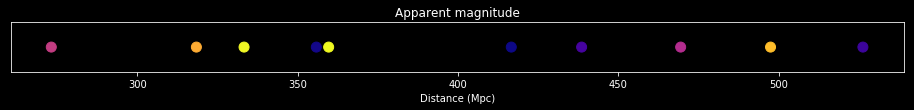

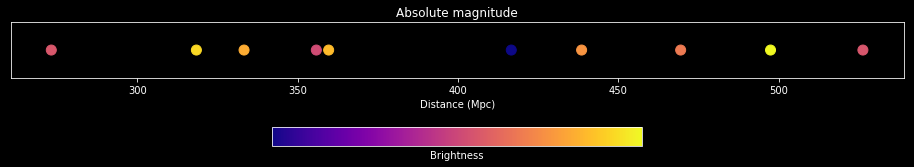

In [10]:
plt.style.use('dark_background')
stars = MW_Cepheids['Object']
distance = MW_Cepheids['distance']
m_V = np.flip(MW_Cepheids['m_V'], 0)
M_V = np.flip(MW_Cepheids['M_V'], 0)

plt.figure(figsize=(16, 2))
plt.subplot(2, 1, 1)
plt.scatter(x=distance, y=np.zeros(distance.size), s=100, c=m_V, cmap='plasma', )
plt.tick_params(axis='both', left='off', top='off', right='off', labelleft='off')
plt.xlabel('Distance (Mpc)')
plt.title('Apparent magnitude')

plt.figure(figsize=(16, 5))
plt.subplot(2, 1, 2)
plt.scatter(x=distance, y=np.zeros(distance.size), s=100, c=M_V, cmap='plasma', )
plt.tick_params(axis='both', left='off', top='off', right='off', labelleft='off')
plt.xlabel('Distance (Mpc)')
plt.title('Absolute magnitude')

cbar = plt.colorbar(orientation='horizontal', pad=0.4)
cbar.set_label("Brightness")
cbar.set_ticks([])
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
pylab.rcParams['figure.figsize'] = (16.0, 14.0)
matplotlib.rcParams['font.family'] = 'serif'

### Brightness model

The dependence of absolute brightness on the period of pulsation is modelled using a linear function for each band:

$$
\begin{align}
M_V &= \alpha_V \log_{10}{P} + \beta_V \\
M_I &= \alpha_I \log_{10}{P} + \beta_I
\end{align}
$$

The aim here is to use the```scipy.optimize.curve_fit()```method to find the coefficients $\alpha$ and $\beta$.

In [11]:
Period = np.asarray(MW_Cepheids['Period'])
logPeriod = np.log10(Period)
P_shift = np.mean(logPeriod) # Shift to remove correlations (this is discussed in more detail below)
logPeriod -=P_shift

In [12]:
def model(x, a, b):
    """Linear fit."""
    y = a*x + b
    return y

def chisq(y, sig_y, y_m):
    """Takes data, model, and error vectors and returns the chi-square."""
    chi2 = np.sum(((y-y_m)**2)/(sig_y**2))
    return chi2

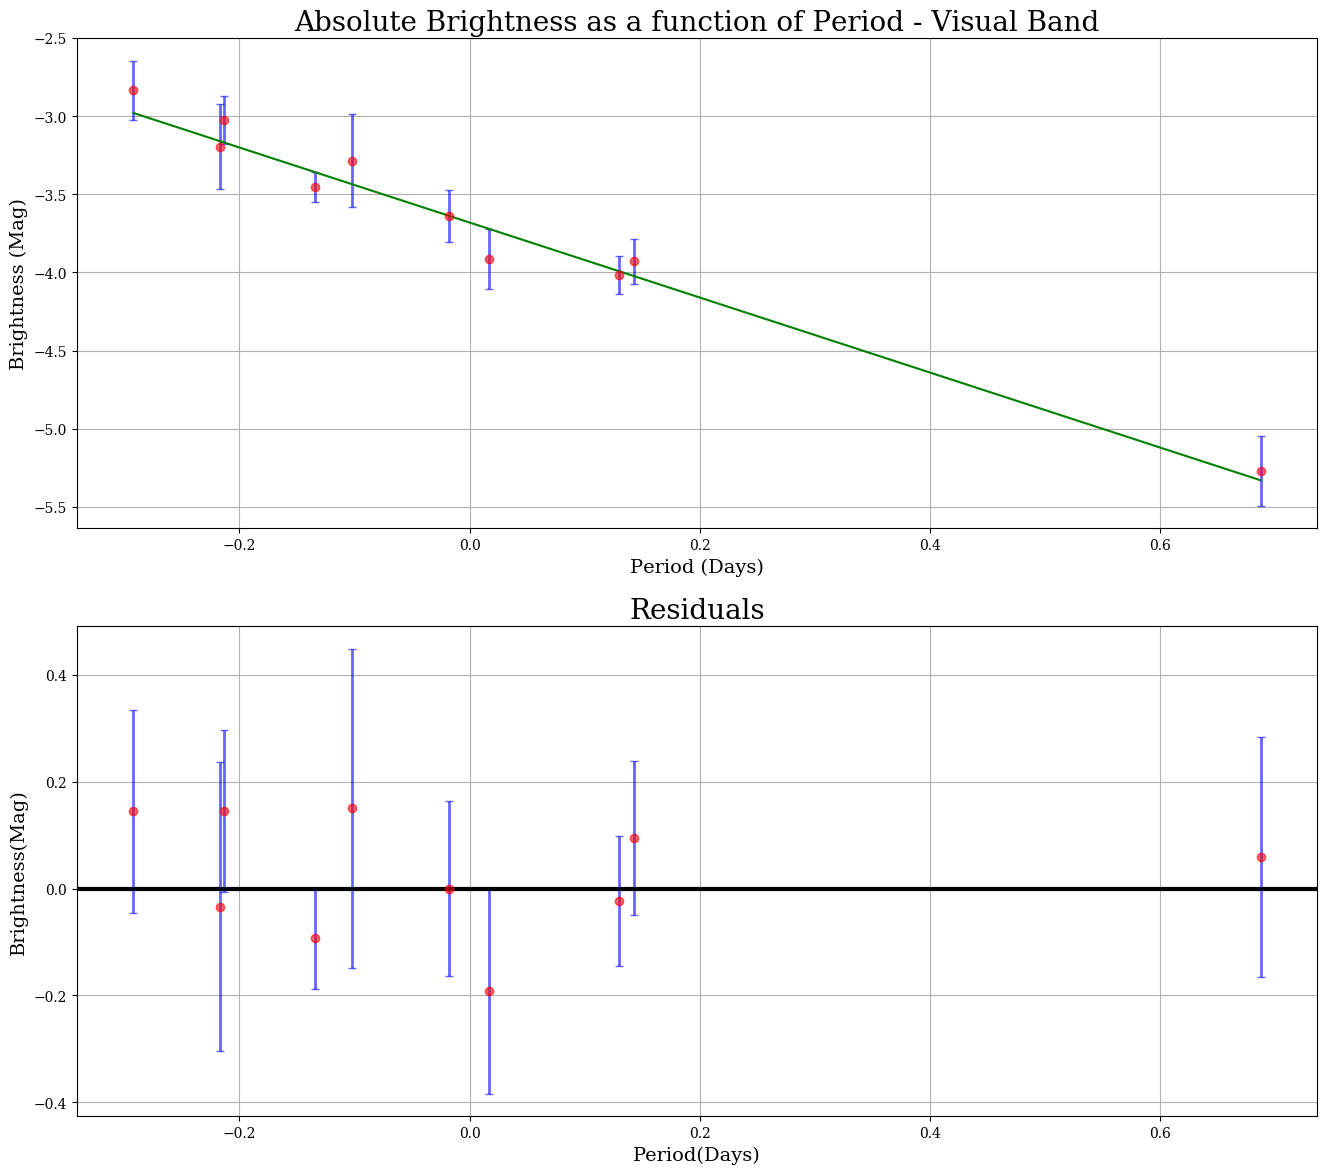

In [13]:
# Visual band
coeffs_V, covar_V = opt.curve_fit(f=model, xdata=logPeriod, ydata=MV, sigma=MV_sigmas, absolute_sigma=True)
# Infrared band
coeffs_I, covar_I = opt.curve_fit(f=model, xdata=logPeriod, ydata=MI, sigma=MI_sigmas, absolute_sigma=True)

# Fit the models
ys_V = coeffs_V[0]*(logPeriod) + coeffs_V[1]
ys_I = coeffs_I[0]*(logPeriod) + coeffs_I[1]

# ================
# Visual band plot
# ================
# Plot data and fit model
plt.subplot(2, 1, 1)
plt.errorbar(logPeriod, MV, yerr=MV_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(logPeriod, ys_V, linestyle='-', color='green')
plt.xlabel('Period (Days)', fontsize=14)
plt.ylabel('Brightness (Mag)', fontsize=14)
plt.title('Absolute Brightness as a function of Period - Visual Band', fontsize=20)
plt.grid(which='both')

# Plot the residuals to try and see any patterns
plt.subplot(2, 1, 2)
plt.errorbar(logPeriod, MV-ys_V, yerr=MV_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(logPeriod, MV-ys_V, linestyle='None')
plt.axhline(y=0, color='k', linewidth=3)

plt.xlabel('Period(Days)', fontsize=14)
plt.ylabel('Brightness(Mag)', fontsize=14)
plt.title('Residuals', fontsize=20)
plt.grid(which='both')
plt.show()

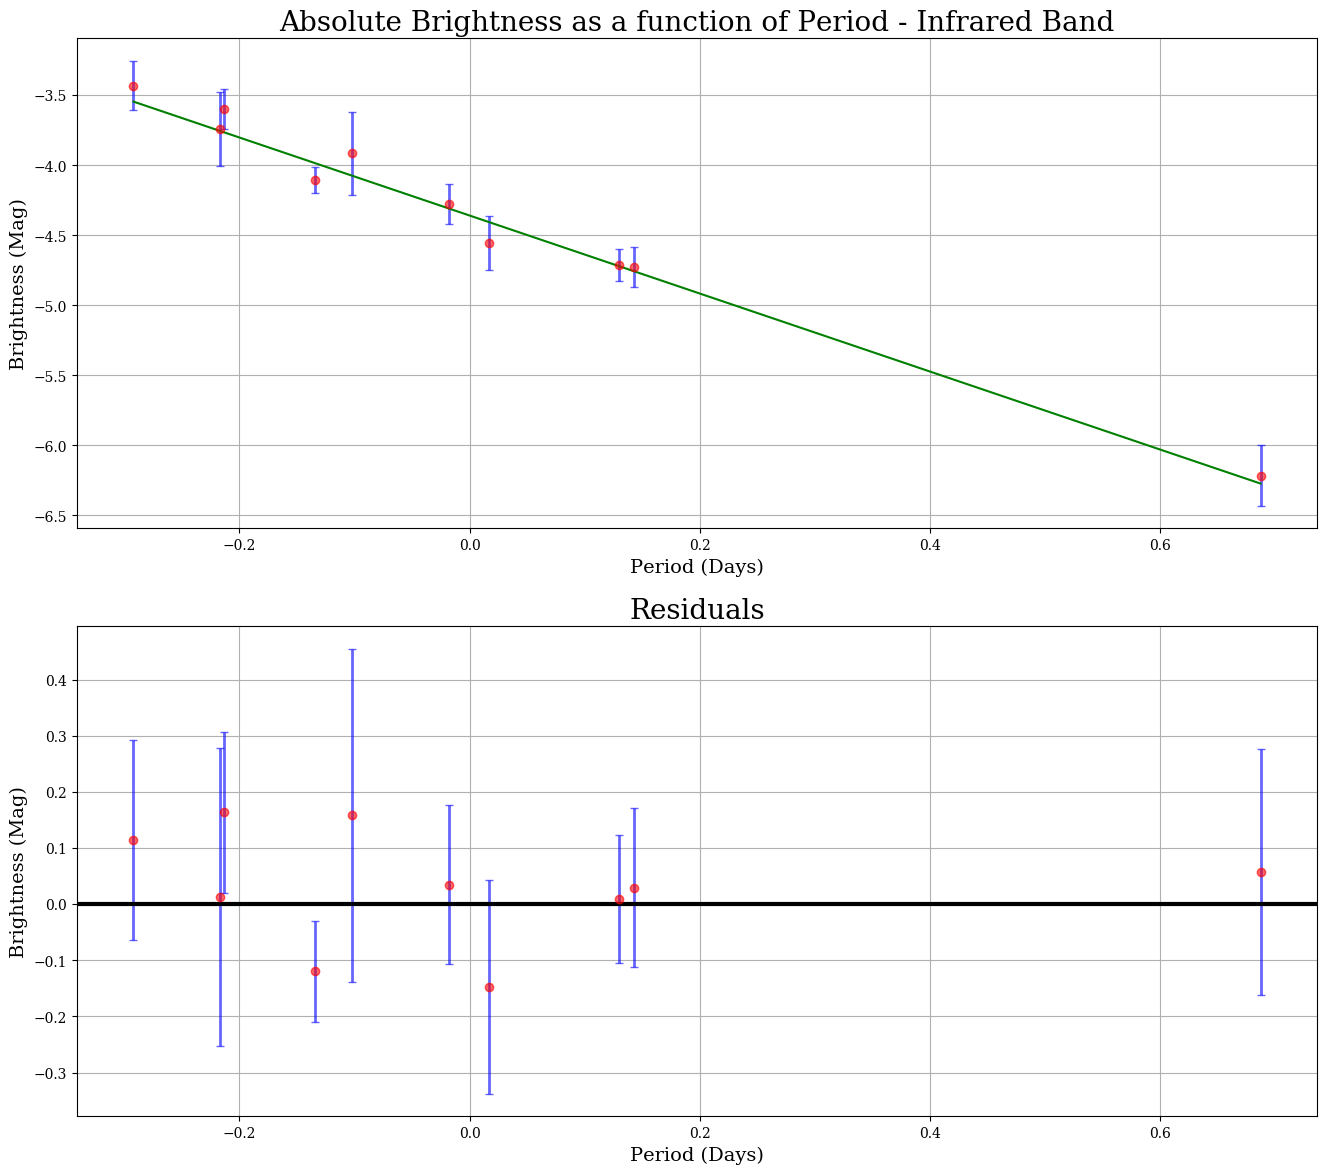

In [14]:
# ==================
# Infrared band plot
# ==================
# Plot data and fit model
plt.subplot(2, 1, 1)
plt.errorbar(logPeriod, MI, yerr=MI_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(logPeriod, ys_I, linestyle='-', color='green')
plt.xlabel('Period (Days)', fontsize=14)
plt.ylabel('Brightness (Mag)', fontsize=14)
plt.title('Absolute Brightness as a function of Period - Infrared Band', fontsize=20)
plt.grid(which='both')

# Plot residuals
plt.subplot(2, 1, 2)
plt.errorbar(logPeriod, MI-ys_I, yerr=MI_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(logPeriod, MI-ys_I, linestyle='None')
plt.axhline(y=0, color='k', linewidth=3)

plt.xlabel('Period (Days)', fontsize=14)
plt.ylabel('Brightness (Mag)', fontsize=14)
plt.title('Residuals', fontsize=20)
plt.grid(which='both')
plt.show()

We can see from the plots of the visual and infrared bands that we get a nice linear relationship between pulsation period and luminosity with a fairly even spread of residuals. There is one data point corresponding to the star I Carinae, that lies slightly apart from the other points. However, a visual inspection is enough to convince us that the model would not be significantly effected by its removal, so we can leave it in.

In order to confirm our model, we can calculate the chi-square and reduced chi-square for each band.

In [15]:
chi2_V = chisq(MV, MV_sigmas, ys_V)
reduced_V = chi2_V / (Period.size - 2)
print('Visible Band:')
display(Math(r'\chi^2 = {:.2f}'.format(chi2_V)))
display(Math(r'\chi^2_\nu = {:.2f}'.format(reduced_V)))
chi2_I = chisq(MI, MI_sigmas, ys_I)
reduced_I = chi2_I / (Period.size - 2)
print()
print('Infrared Band:')
display(Math(r'\chi^2 = {:.2f}'.format(chi2_I)))
display(Math(r'\chi^2_\nu = {:.2f}'.format(reduced_I)))

Visible Band:


<IPython.core.display.Math object>

<IPython.core.display.Math object>


Infrared Band:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

These values for the reduced chi-square seem low, and is likely due to the simplified nature of the model used. We can essentially attribute this to intrinsic dispersion, and since the model appears to describe our data quite well, we will accept the values for $\alpha$ and $\beta$.

Before displaying the PL relation values, we must consider any possible correlations of the coefficients. As can be seen in code cell```'In [11]',```the```logPeriod```values have been shifted to center the mean of these values on 0. This is done in order to remove any correlations between the $\alpha$ and $\beta$ values. This tranformation does not change $\alpha$, which is just the gradient of the line, but it does change $\beta$ and the uncertainties in $\beta$. In order to tranform the $\beta$ values, we can use,

$$
\begin{align}
\beta_V &= \alpha_V(-P_{shift}) + \beta_{V0}\\
\beta_I &= \alpha_I(-P_{shift}) + \beta_{I0}
\end{align}
$$

where $\beta_{0}$ are the shifted $\beta$ values, and $P_{shift}$ is the value of the shift in```logPeriod```. As an example of a non_shifted correlation matrix, we can look at the matrix for the visual band values before the transformation:

|            | $\alpha_V$ | $\beta_V$ |
|------------|:----------:|:---------:|
| $\alpha_V$ |1.00        |-0.97      |
| $\beta_V$  |-0.97       |1.00       |

The correlation matrices for both bands after the shift has been applied can be seen below.

In [16]:
corr_matrix_V = np.zeros((2,2))
slope_error = np.sqrt(covar_V[0, 0])
intercept_error = np.sqrt(covar_V[1, 1])
corr_matrix_V[0,0] = covar_V[0,0]/(slope_error**2)
corr_matrix_V[1,1] = covar_V[1,1]/(intercept_error**2)
corr_matrix_V[0,1] = covar_V[0,1]/(slope_error*intercept_error)
corr_matrix_V[1,0] = covar_V[1,0]/(slope_error*intercept_error)
print(corr_matrix_V)

[[ 1.          0.08680722]
 [ 0.08680722  1.        ]]


In [17]:
corr_matrix_I = np.zeros((2,2))
slope_error = np.sqrt(covar_I[0, 0])
intercept_error = np.sqrt(covar_I[1, 1])
corr_matrix_I[0,0] = covar_I[0,0]/(slope_error**2)
corr_matrix_I[1,1] = covar_I[1,1]/(intercept_error**2)
corr_matrix_I[0,1] = covar_I[0,1]/(slope_error*intercept_error)
corr_matrix_I[1,0] = covar_I[1,0]/(slope_error*intercept_error)
print(corr_matrix_I)

[[ 1.          0.09708606]
 [ 0.09708606  1.        ]]


By applying this shift, we can see that the correlation between $\alpha$ and $\beta$ is now negligible. We now have the values for the period-luminosity relation for both the visual band and the infrared band, along with the associated uncertainties:

In [18]:
alpha_V = coeffs_V[0]
sigma_alpha_V = np.sqrt(covar_V[0,0])
alpha_I = coeffs_I[0]
sigma_alpha_I = np.sqrt(covar_I[0,0])
# Pretransformed betas and beta sigmas
trans_beta_V = coeffs_V[1]
trans_sigma_beta_V = np.sqrt(covar_V[1,1])
trans_beta_I = coeffs_I[1]
trans_sigma_beta_I = np.sqrt(covar_I[1,1])
# Transform betas and beta sigmas
beta_V = ((alpha_V*(-P_shift)) + trans_beta_V)
sigma_beta_V = np.sqrt(((P_shift**2)*(sigma_alpha_V**2))+(trans_sigma_beta_V**2))
beta_I = ((alpha_I*(-P_shift)) + trans_beta_I)
sigma_beta_I = np.sqrt(((P_shift**2)*(sigma_alpha_I**2))+(trans_sigma_beta_I**2))

display(Math(r"\alpha_V = {:.2f} \pm {:.2f}".format(alpha_V, sigma_alpha_V)))
display(Math(r"\beta_V = {:.2f} \pm {:.2f}".format(beta_V, sigma_beta_V)))
display(Math(r"\alpha_I = {:.2f} \pm {:.2f}".format(alpha_I, sigma_alpha_I)))
display(Math(r"\beta_I = {:.2f} \pm {:.2f}".format(beta_I, sigma_beta_I)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Distances to nearby Galaxies

Now that we have a relationship between the period of pulsation and the absolute magnitude of a Cepheid, we can start looking at Cepheid stars in other galaxies.

In [19]:
galaxy = pd.read_csv('hst_gal1_cepheids.dat', skiprows=[0], sep='\s+')
galaxy.head()

,#Name,logP,m_V,m_I
0,C2-V4,1.623,24.55,23.53
1,C2-V8,1.602,24.87,24.05
2,C2-V10,1.342,24.71,24.23
3,C2-V12,1.415,25.03,24.05
4,C2-V13,1.260,25.83,24.99


In [20]:
filename = 'galaxy_data.dat'
galaxy_data = pd.read_csv(filename, skiprows=[0], sep='\s+')
galaxy_data = galaxy_data.drop(['(mag)'], axis=1)
galaxy_data = galaxy_data.rename(columns={'(km/s)':'Extinction'})
galaxy_data

,#Name,Velocity,Extinction
0,NGC3627,427,0.0992
1,NGC3982,1510,0.0434
2,NGC4496A,1152,0.0775
3,NGC4527,1152,0.0682
4,NGC4536,1152,0.0558
5,NGC4639,1152,0.0806
6,NGC5253,170,0.1736
7,IC4182,303,0.0434


The first dataframe above is an example of the information on Cepheid stars in galaxy NGC 3627. All other data files contain the same variable information, but the lengths of the files are not the same. The second data frame contains measured recession velocities of, and extinction *within* each respective galaxy. In order to calculate the Hubble Constant, we must find the distance to each galaxy. To find the distance to each galaxy, we first find the distance to each star within the galaxy given by,

$$ d = 10^{\frac{1}{5}(m - M + 5 - A)} $$

and then calculate the mean distance, and take this to be the distance to that galaxy. The uncertainty is then taken to be the standard error on the mean distance. This of course makes the assumption that the errors on the distance are approximately gaussian which is reasonable.

However, before the distance can be found, we can use the relationship in the previous section to determine the intrinsic brightness of the Cepheid stars in each galaxy. The function below is responsible for processing all of the individual galaxy tables, and returns distance and distance uncertainty vectors.

In [21]:
def process_galaxy_data(galaxy_data, galaxies, alpha_V, alpha_I, beta_V, beta_I, sigma_alpha_V, sigma_alpha_I,
                        sigma_beta_V, sigma_beta_I):
    """Takes an array of filenames corresponding to galaxies, and returns an array of distances 
    to the galaxies, as well as the associated uncertainties."""
    
    AVs = galaxy_data['Extinction']
    
    stars = []
    star_sigmas = []
    velocities = []
    distances = []
    distance_sigmas = []
    # These are purely for the pretty plot at the end illustrating magnitude and distance.
    
    i = 0
    for filename in galaxies:
        AV = AVs[i]
        galaxy = pd.read_csv(filename, skiprows=[0], sep='\s+')
        mV = galaxy['m_V']
        mI = galaxy['m_I']
        P = galaxy['logP']
        # Use PL relation to find absolute magnitude
        MV = alpha_V * P + beta_V
        MI = alpha_I * P + beta_I
        # Uncertainties in M
        sigma_MV = np.sqrt((P**2)*(sigma_alpha_V**2) + (sigma_beta_V**2))
        sigma_MI = np.sqrt((P**2)*(sigma_alpha_I**2) + (sigma_beta_I**2))
        # Find the distance to each star
        distance_V = 10 ** ((1/5)*(mV - MV + 5 - AV))
        distance_I = 10 ** ((1/5)*(mI - MI + 5 - (0.556*AV)))
        # Find the mean of those distances
        total_distances = np.concatenate((distance_V, distance_I))
        stars.append(total_distances)
        mean_distance = np.mean(total_distances)
        distance = mean_distance / 1e6
        distances.append(distance)
        # Uncertainty in the distance - standard error on the mean of the distance
        distance_sigma = np.std(total_distances) / np.sqrt(total_distances.size)
        distance_sigma = distance_sigma / 1e6
        distance_sigmas.append(distance_sigma)
        
        i += 1
        
    return np.asarray(distances), np.asarray(distance_sigmas)

Before calling the function above, we should consider the possibility that one or more of our variables have errors that are not gaussian. If we consider the distance modulus, the major contributor to the uncertainty will be that for absolute magnitude. Since the errors for the absolute magnitudes are propagated from the $\alpha$ and $\beta$ parameters, which we ensured were independent and with approximately gaussian errors, it is reasonable to continue under the assumption that the uncertainty on the absolute magnitudes are also gaussian. Although th uncertainies for absolute magnitude are calculated above, they do not actually contribute to the uncertainty in distance, since we are taking the standard error on the mean of the distance.

In [22]:
galaxies = ['hst_gal1_cepheids.dat', 'hst_gal2_cepheids.dat', 'hst_gal3_cepheids.dat',
            'hst_gal4_cepheids.dat', 'hst_gal5_cepheids.dat', 'hst_gal6_cepheids.dat',
            'hst_gal7_cepheids.dat', 'hst_gal8_cepheids.dat']

distances, distance_sigmas = process_galaxy_data(galaxy_data, galaxies, alpha_V, alpha_I, beta_V, beta_I,
                                                 sigma_alpha_V, sigma_alpha_I, sigma_beta_V, sigma_beta_I)

In [23]:
galaxy_data['distance(Mpc)'] = distances
galaxy_data['err(distance)'] = distance_sigmas
velocities = galaxy_data.Velocity
galaxy_data

,#Name,Velocity,Extinction,distance(Mpc),err(distance)
0,NGC3627,427,0.0992,10.401306,0.215308
1,NGC3982,1510,0.0434,21.173074,0.733859
2,NGC4496A,1152,0.0775,14.063735,0.204613
3,NGC4527,1152,0.0682,13.997301,0.338941
4,NGC4536,1152,0.0558,14.749687,0.252229
5,NGC4639,1152,0.0806,20.321809,0.652797
6,NGC5253,170,0.1736,3.596511,0.097117
7,IC4182,303,0.0434,4.303065,0.075640


As can be seen above, we now have the necessary information to calculate the Hubble Constant.

## Hubble Constant and the Age of the Universe

Hubble's Law is given by the linear relation,

$$
\begin{align}
v_{rec} = H_0D_{gal}
\end{align}
$$

where $v_{rec}$ is the recession velocity of the galaxy as the Universe expands, and $D_{gal}$ is the distance to that galaxy. Since the recession velocity is known very precisely and we do not have any uncertainty, if we plot recession velocity as a function of distance, then we have no $\sigma$ values to feed```curve_fit()```and will have to estimate uncertainties for velocity. However we can plot the function,

$$D_{gal} = \frac{1}{H_0}v_{rec}$$

and use the standard errors that we found for distance. Although it is not shown below, simply using these errors results in a large value of $\chi^2$. This indicates that formally, the model is not a good fit. However, with the plots seen below, the model appears to fit the data, and there are no obvious patterns in the residuals. If we choose to accept the model, we do so on the assumption that we have underestimated the intrinsic dispersion of our data. Therefore we will estimate this intrinsic dispersion in order to achieve  $\:\chi^2_{\nu} = 1$.

We will assume that this extra error is constant for all data points, and therefore,

$$ \delta_f^2 = \delta_i^2 + \delta_{int}^2 $$

where $\delta_{int}$ is the value of the intrinsic dispersion, adjusted to acheive $\:\chi^2_{\nu} = 1$.

### Linear Plot

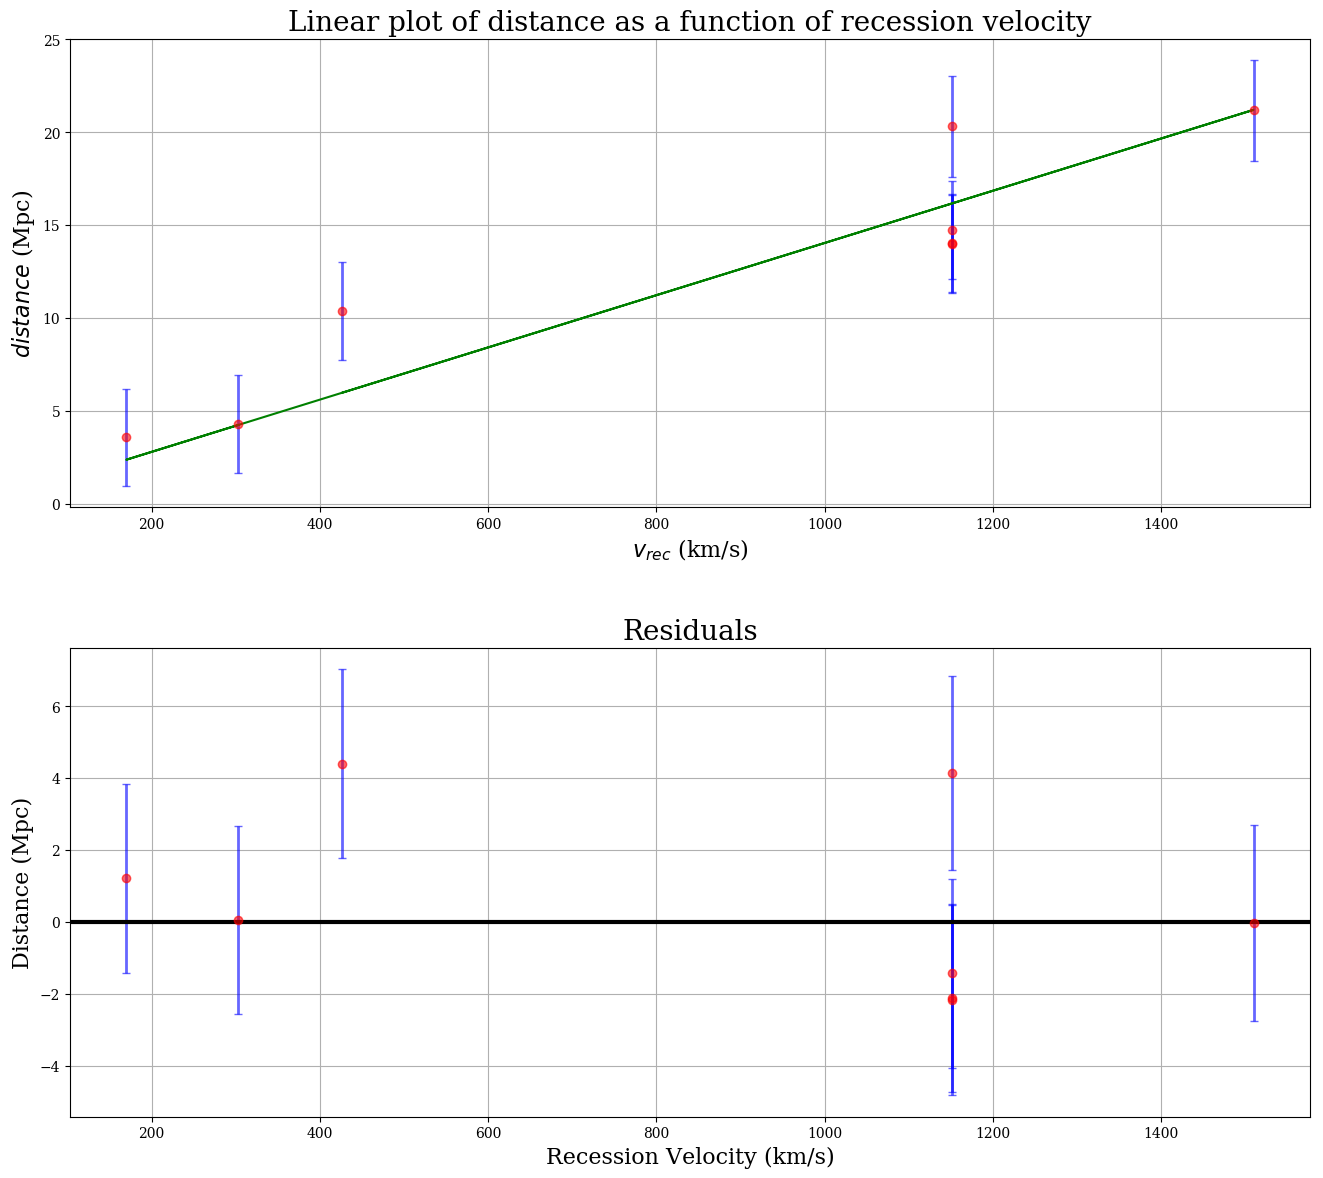

In [24]:
def hubble_function(v_rec, a):
    distances = a * v_rec
    return distances

# Make an estimate on the distance_sigmas
sigma_lin_int = 2.62
lin_distance_sigmas = np.sqrt(distance_sigmas**2 + sigma_lin_int**2)

coeffs_H, covar_H = opt.curve_fit(f=hubble_function, xdata=velocities, ydata=distances, sigma=lin_distance_sigmas,
                                 absolute_sigma=False)

alpha = coeffs_H[0]
k = velocities*(alpha)
H = 1/alpha

sigma_alpha = np.sqrt(covar_H[0,0])
sigma_H = np.sqrt(((1/(alpha**2))**2) * (sigma_alpha**2))

plt.subplot(2, 1, 1)
plt.errorbar(velocities, distances, yerr=lin_distance_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(velocities, k, color='green')
plt.grid(which='both')
plt.title("Linear plot of distance as a function of recession velocity", fontsize=20)
plt.xlabel(r'$v_{rec}$ (km/s)', fontsize=16)
plt.ylabel(r'$distance$ (Mpc)', fontsize=16)

plt.subplot(2, 1, 2)
plt.errorbar(velocities, distances-k, yerr=lin_distance_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(velocities, distances-k, linestyle='None')
plt.axhline(y=0, color='k', linewidth=3)

plt.grid(which='both')
plt.title('Residuals', fontsize=20)
plt.xlabel('Recession Velocity (km/s)', fontsize=16)
plt.ylabel('Distance (Mpc)', fontsize=16)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [25]:
chi2_H = chisq(distances, lin_distance_sigmas, k)
reduced_H = chi2_H / (distances.size - 1)
display(Math(r'\chi^2 = {:.2f}'.format(chi2_H)))
display(Math(r'\chi^2_\nu = {:.2f}'.format(reduced_H)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

From the coefficient found by```curve_fit(),``` we can find the Hubble Constant:

In [26]:
display(Math(r'H_0 = {:.2f} \pm {:.2f} \:(km/s)/Mpc'.format(H, sigma_H)))

<IPython.core.display.Math object>

### Age of the Universe

From here, we can now approximate the age of the universe by recognizing that the time taken for the galaxies to move apart a distance $D_{gal}$ at a velocity $v_{rec}$, is simply,

$$ \tau = \frac{D_{gal}}{v_{rec}} = \frac{1}{H_0} $$

with an uncertainty,

$$ 
\begin{align}
\left( \delta \tau \right)^2 &= \left( \frac{\partial \tau}{\partial H_0} \right)^2 \left( \delta H_0 \right)^2 \\
\\
\delta \tau &= \sqrt{ \left( -\frac{1}{H_0^2} \right)^2 \left( \delta H_0 \right)^2 }
\end{align}
$$

We also have to remember that the Hubble Constant has units of (km/s)/Mpc, and this must be transformed such that the age of the universe is given in billions of years.

In [27]:
H_reduced = H / 3.086e19
age_of_universe = 1 / H_reduced
age_of_universe = age_of_universe / (31536000e9)
sigma_age = np.sqrt((((3.086e19) / ((H**2)*31536000e9))**2) * (sigma_H ** 2))
display(Math(r"\tau = {:.3f} \pm {:.3f}\: Billion\: years.".format(age_of_universe, sigma_age)))

<IPython.core.display.Math object>

Performing a linear fit with our data therefore gives us a Hubble constant of $71.20 \pm 4.82$ (km/s)/Mpc, and an age of $13.744 \pm 0.930$ billion years. For reference, the most recent measurement of the Hubble constant was $73.52 \pm 1.62$ calculated from data on Cepheid stars gathered by the Hubble Space Telescope and Gaia[1]. An estimate on the age of the Universe is $13.799 \pm 0.021$ billion years from Planck observations of temperature and polarization anisotropies of the CMB[2]. So, our result from the linear fit agrees with established measurements to within the uncertainties obtained.

However, it may also be beneficial to perform a log-log fit with our data. A log plot with a linear model serves to spread the data out more. If the data shifts more towards a straighter line, it could also suggest that the data is non-linear and instead could be closer to a power law.

### Log-log Plot

In [28]:
log_velocities = np.log10(velocities)
log_distances = np.log10(distances)

# Correct the error in order to bring down the reduced chi-square
sigma_log_int = 2.95
distance_sigmas = np.sqrt(distance_sigmas**2 + sigma_log_int**2)
log_distance_sigmas = np.sqrt(((1 / (distances*np.log(10)))**2)*((distance_sigmas)**2))

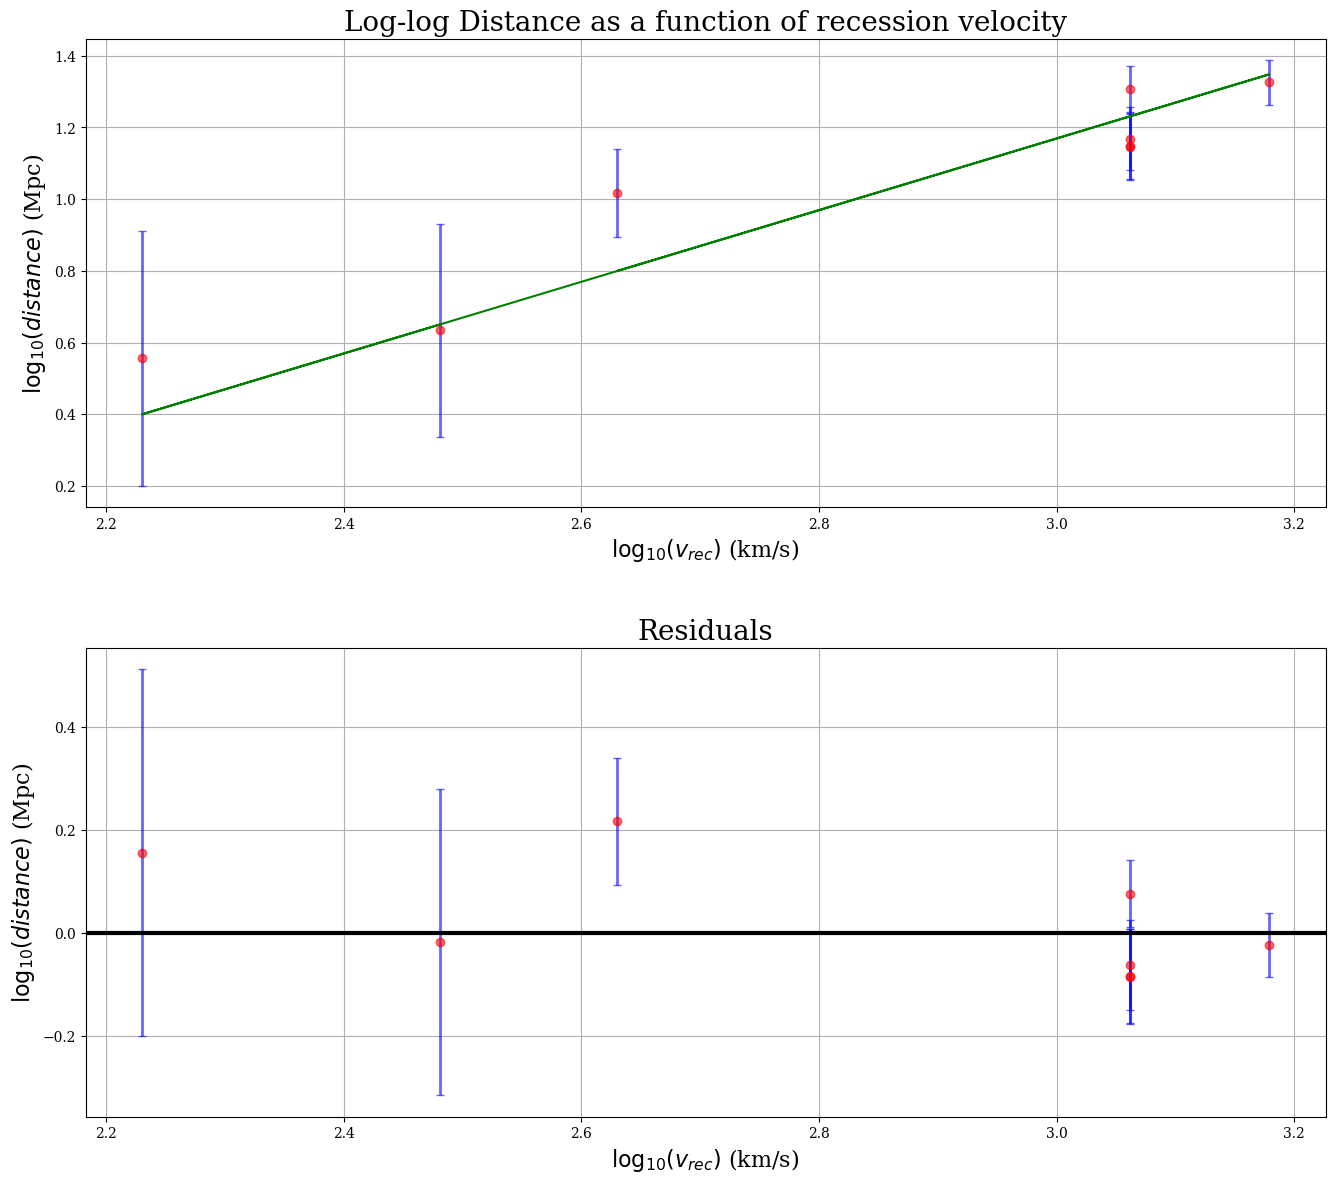

In [29]:
def hubble_function(v_rec, a):
    distances = v_rec - a
    return distances

coeffs_H, covar_H = opt.curve_fit(f=hubble_function, xdata=log_velocities, ydata=log_distances, sigma=log_distance_sigmas,
                                 absolute_sigma=False)

alpha = coeffs_H[0]
d = log_velocities - alpha
H = (10**alpha)

sigma_alpha = np.sqrt(covar_H[0,0])

sigma_H = np.sqrt((((10**alpha)*(np.log(10)))**2) * (sigma_alpha**2))

plt.subplot(2, 1, 1)
plt.errorbar(log_velocities, log_distances, yerr=log_distance_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(log_velocities, d, color='green')
plt.grid(which='both')
plt.title("Log-log Distance as a function of recession velocity", fontsize=20)
plt.xlabel(r'$\log_{10}(v_{rec})$ (km/s)', fontsize=16)
plt.ylabel(r'$\log_{10}(distance)$ (Mpc)', fontsize=16)

plt.subplot(2, 1, 2)
plt.errorbar(log_velocities, log_distances-d, yerr=log_distance_sigmas, marker='o', linestyle='None', color='r', ecolor='b',
            elinewidth=2, capsize=3, alpha=0.6)
plt.plot(log_velocities, log_distances-d, linestyle='None')
plt.axhline(y=0, color='k', linewidth=3)
plt.grid(which='both')
plt.title('Residuals', fontsize=20)
plt.xlabel(r'$\log_{10}(v_{rec})$ (km/s)', fontsize=16)
plt.ylabel(r'$\log_{10}(distance)$ (Mpc)', fontsize=16)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [30]:
chi2_H = chisq(log_distances, log_distance_sigmas, d)
reduced_H = chi2_H / (log_distances.size - 1)
display(Math(r'\chi^2 = {:.2f}'.format(chi2_H)))
display(Math(r'\chi^2_\nu = {:.2f}'.format(reduced_H)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Once again, we can find the Hubble constant:

In [31]:
display(Math(r'H_0 = {:.2f} \pm {:.2f} \:(km/s)/Mpc'.format(H, sigma_H)))

<IPython.core.display.Math object>

### Age of Universe

As with the linear plot, we now find the age of the universe:

In [32]:
# Convert megaparsecs to km
H_reduced = H / 3.086e19
age_of_universe = 1 / H_reduced
age_of_universe = age_of_universe / (31536000e9)
sigma_age = np.sqrt((((3.086e19) / ((H**2)*31536000e9))**2) * (sigma_H ** 2))
display(Math(r"\tau = {:.3f} \pm {:.3f}\: Billion\: years.".format(age_of_universe, sigma_age)))

<IPython.core.display.Math object>

Performing a logarithmic fit with our data therefore gives us a Hubble constant of $67.72 \pm 5.06$ (km/s)/Mpc, and an age of $14.450 \pm 1.081$ billion years. Comparing this with the result from the linear fit, we can see that they agree to within the defined uncertainties. This further indicates that the uncertainties added to the propogated uncertainties is more likely to be intrinsic and not due to some systematic error. The additional uncertainty needed in order to bring both models to within a $\chi_{\nu}^2$ of 1 were also very similar. There could be a number of sources of this additional uncertainty:

**Recession velocities**
The values for $v_{rec}$ should have some amount of uncertainty. The stars contained within the galaxy will likely have some additional velocity relative to the recession velocity of the galaxy.

**Extinctions**
The values for the extinction only account for that present in our own galaxy, and not any possible extinction effects within the star's galaxy.

**Non-Linear Model**
The relationship between distance and recession velocity may not in fact be linear.

## References

[1] Adam G. Riess, Stefano Casertano, Wenlong Yuan, Lucas Macri, Beatrice Bucciarelli, Mario G. Lattanzi, John W. MacKenty, J. Bradley Bowers, Weikang Zheng, Alexei V. Filippenko, Caroline Huang, Richard I. Anderson.
Milky Way Cepheid Standards for Measuring Cosmic Distances and Application to Gaia DR2: Implications for the Hubble Constant. 
The Astrophysical Journal. 2018.
arXiv:1804.10655

[2] Planck 2015 results - XIII. Cosmological parameters
Planck Collaboration, P. A. R. Ade, et al
A&A, 594 (2016) A13
DOI: https://doi.org/10.1051/0004-6361/201525830